# Inference and Validation

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
parameters = {'batch_size' : 64,
              'shuffle' : True
             }

In [3]:
transformation = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5,0.5,0.5 ) ,(0.5,0.5,0.5 )) 
                                    ])

traindata = datasets.FashionMNIST('F_MNIST_data', train=True, download = False, transform = transformation)
testdata  = datasets.FashionMNIST('F_MNIST_data', train=False, download = False, transform = transformation)

trainloader = torch.utils.data.DataLoader(traindata, **parameters)
testloader  = torch.utils.data.DataLoader(testdata,  **parameters)

Let's build our classifier, which has 2 hidden layers. 

In [4]:
from torch import nn, optim 
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,  64)
        self.fc4 = nn.Linear( 64,  10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x 

The goal of validation is to measure the performance of the model's performance on data that is not a part of the training set. This measure is typically `accuracy`, yet, some other options are `precision and recall` and `top-5 error rate`. Let's first focus on **accuracy**.

In [5]:
model = Classifier() 

images, labels = next(iter(testloader))

# get class probabilities
probs = torch.exp(model(images))
print(probs.shape)

torch.Size([64, 10])


`probs.topk` method returns the k highest values. Since we are interested in most like class, we can use `probs.topk(1)`

In [6]:
top_prob, top_class = probs.topk(1, dim=1)

# most likely classes for the first 10 examples
print(top_class[:10:])

tensor([[9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9]])


In [7]:
print(top_class.shape)
print(labels.shape)

torch.Size([64, 1])
torch.Size([64])


We want to count the number of correct predictions. Following code would be useful for this. 
```python 
equals = top_class == labels
```
However, observe that the shapes of top_class and labels don't match. Therefore, we view one in the other's shape using the following code
```python
labels.view(*top_class.shape)
```

In [8]:
equals = top_class == labels.view(*top_class.shape)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy in the this batch is {accuracy.item()*100}%')

Accuracy in the this batch is 12.5%


In [9]:
model = Classifier()
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0 

train_loss, test_loss = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item()
#    train_loss.append(running_loss)
    else:
        val_running_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for val_images, val_labels in testloader: 
                val_log_probs = model(val_images)
                val_loss = criterion(val_log_probs, val_labels)
                val_running_loss += val_loss.item()
                
                probs = model(val_images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = top_class == val_labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                
        train_loss.append(running_loss/len(trainloader))
        test_loss.append(val_running_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs), 
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)), 
              "Test Loss: {:.3f}.. ".format(val_running_loss/len(testloader)), 
              "Test Accuracy: {:.3f}".format(accuracy / len(testloader))
             )
        
        

Epoch: 1/30..  Training Loss: 0.518..  Test Loss: 0.430..  Test Accuracy: 0.846
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.422..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 4/30..  Training Loss: 0.331..  Test Loss: 0.398..  Test Accuracy: 0.864
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.407..  Test Accuracy: 0.858
Epoch: 6/30..  Training Loss: 0.300..  Test Loss: 0.364..  Test Accuracy: 0.876
Epoch: 7/30..  Training Loss: 0.290..  Test Loss: 0.367..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.280..  Test Loss: 0.373..  Test Accuracy: 0.872
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.389..  Test Accuracy: 0.869
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.367..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.359..  Test Accuracy: 0.877
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.389..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.249.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import matplotlib.pyplot as plt

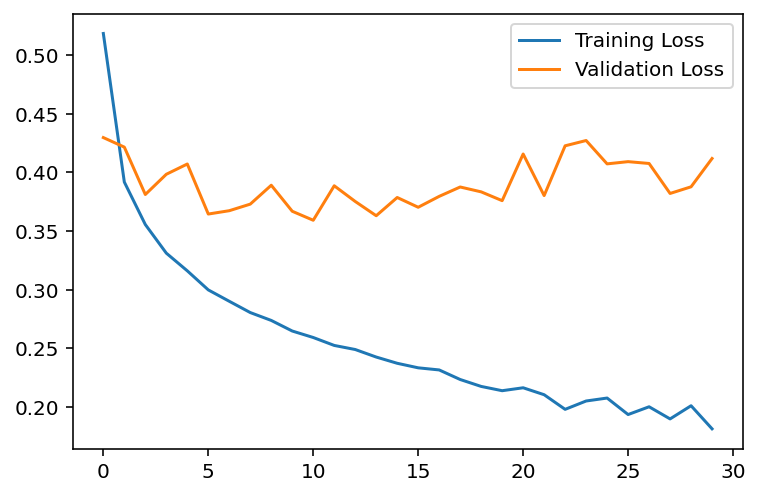

In [11]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()

## Overfitting 

As can be seen from the graph above, as our model learns, that is to say training loss decreases, the validation loss does not decrease, even increases. This is because the out of sample prediction capabilities of the model gets worse as it learns. This is called `overfitting`. One way to overcome overfitting is adding droput option to the model. In layer at which we include a dropout option, the model drops out some of the neurons with the pre-specified probability. It forces the network share information between the layers. 

Now let's add dropout option all layers (other than the output layer) to see if we solve the overfitting problem. For this we will use `nn.Dropout` method. One thing to note here is that when we train the model we use the dropout, however when we validate the model we do not use the dropouts. Therefore, in training phase we turn it on by `model.train()` and during the validation phase we turn it off by `model.eval()`. 

In [12]:
import torch 
from torch import nn, optim 
import torch.nn.functional as F 

class Classifier_Drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,  64)
        self.fc4 = nn.Linear( 64,  10)
        
        # initialize dropout module with 0.2 drop prob.
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x         

In [13]:
model = Classifier_Drop()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, validation_losses = [], [] 

for e in range(epochs): 
    train_running_loss = 0
    
    for images, labels in trainloader: 
        optimizer.zero_grad()
        
        probs = model(images)
        loss = criterion(probs, labels)
        loss.backward()         
        optimizer.step()
        
        train_running_loss += loss.item() 
    
    else: 
        val_running_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval() 
            for images, labels in testloader: 
                log_probs = model(images) 
                val_running_loss += criterion(log_probs, labels) 
                
                probs = torch.exp(log_probs) 
                top_p, top_class = probs.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(train_running_loss/len(trainloader))
        validation_losses.append(val_running_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs), 
              "Training Loss: {:.3f}.. ".format(train_running_loss/len(trainloader)), 
              "Validation Loss: {:.3f}.. ".format(val_running_loss/len(testloader)), 
              "Validation Accuracy: {:.3f}.".format(accuracy / len(testloader))
             )        


Epoch: 1/30..  Training Loss: 0.610..  Validation Loss: 0.490..  Validation Accuracy: 0.827.
Epoch: 2/30..  Training Loss: 0.484..  Validation Loss: 0.470..  Validation Accuracy: 0.833.
Epoch: 3/30..  Training Loss: 0.452..  Validation Loss: 0.423..  Validation Accuracy: 0.846.
Epoch: 4/30..  Training Loss: 0.433..  Validation Loss: 0.427..  Validation Accuracy: 0.845.
Epoch: 5/30..  Training Loss: 0.420..  Validation Loss: 0.400..  Validation Accuracy: 0.859.
Epoch: 6/30..  Training Loss: 0.414..  Validation Loss: 0.424..  Validation Accuracy: 0.854.
Epoch: 7/30..  Training Loss: 0.404..  Validation Loss: 0.415..  Validation Accuracy: 0.855.
Epoch: 8/30..  Training Loss: 0.393..  Validation Loss: 0.399..  Validation Accuracy: 0.858.
Epoch: 9/30..  Training Loss: 0.395..  Validation Loss: 0.406..  Validation Accuracy: 0.857.
Epoch: 10/30..  Training Loss: 0.398..  Validation Loss: 0.399..  Validation Accuracy: 0.858.
Epoch: 11/30..  Training Loss: 0.388..  Validation Loss: 0.379..  Val

Now let's plot the training and validation losses against the number of epochs. 

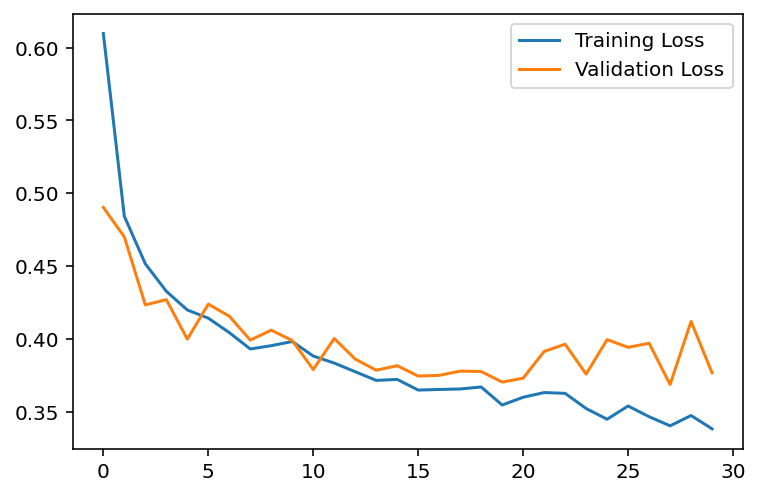

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()


With the help of `nn.Dropout()` module, we have managed to handle overfitting problem for this problem. 